In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from scipy.linalg import sqrtm

# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Nos bajamoslos precios diarios del SP500 y calculamos los precios semanales, mensuales, trimestrales y anuales

start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre
ret_indice = np.log(precios_indice).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [3]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
ret_activos = np.log(precios_activos_sp500).diff().dropna()

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['BRK.B', 'CDAY']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-11)')


In [4]:
ret_indice_sp500_test = ret_indice.loc['2013':]
ret_indice_sp500 = ret_indice.loc[:'2012']

ret_activos_sp500_test = ret_activos.loc['2013':]
ret_activos_sp500 = ret_activos.loc[:'2012']
ret_activos_sp500


Ticker,ADBE,ADI,ADM,ADP,ADSK,AES,AFL,AIG,AJG,ALB,...,WFC,WHR,WM,WMT,WRB,WST,XEL,XRAY,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-04,-0.027869,-0.026568,0.006154,-0.004282,0.029656,0.026317,0.030772,-0.011516,0.007905,0.026668,...,-0.016260,-0.012486,0.011173,0.035299,-0.016807,-0.004576,0.002821,0.000000,-0.013423,-0.019148
1995-01-05,0.038384,0.009570,-0.012346,0.006417,0.000000,0.000000,-0.003796,-0.001288,-0.023905,-0.035718,...,0.010869,0.002510,0.000000,0.011493,0.000000,0.009132,0.002814,0.003929,0.000000,0.008749
1995-01-06,0.020704,0.028171,-0.012500,0.000000,0.009693,0.025642,-0.003809,0.000000,-0.012171,0.018018,...,0.005391,0.007491,-0.011173,0.005698,0.020136,-0.009132,-0.002814,0.042233,0.000000,0.000000
1995-01-09,0.012220,0.011050,0.000000,0.000000,0.030073,-0.025642,-0.015384,0.001288,0.000000,-0.018018,...,-0.016260,0.002485,-0.011300,-0.005698,-0.010018,-0.009217,0.002814,-0.015151,0.010084,0.010398
1995-01-10,0.018055,0.005479,0.006270,0.014816,-0.031749,-0.013072,-0.003885,0.010243,-0.008196,-0.009133,...,0.000000,-0.002485,-0.011429,-0.017291,0.019934,0.004619,0.002805,0.011385,-0.003350,-0.020906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-0.004785,-0.001898,-0.001441,-0.001739,0.005339,-0.009216,-0.000558,0.013154,-0.001998,0.004369,...,-0.001742,-0.007724,-0.000296,-0.001166,-0.001553,-0.002768,-0.001115,-0.006464,0.000252,-0.003729
2012-12-26,0.000533,-0.007628,-0.009781,-0.006633,-0.014966,-0.002782,-0.005220,0.004252,-0.004869,-0.004207,...,-0.002618,-0.008585,-0.003256,-0.008495,-0.015140,-0.007232,-0.012715,-0.012188,-0.013423,-0.007501
2012-12-27,-0.006680,0.002390,0.000728,-0.003685,-0.000854,-0.012144,-0.009201,-0.010808,-0.004893,0.000486,...,-0.004379,0.014137,-0.000593,0.002937,-0.008187,0.010369,-0.000376,-0.004308,0.003817,0.000470


In [5]:
num_act = ret_activos_sp500.shape[1]
matriz_cov = ret_activos_sp500.cov().to_numpy()

retornos_esperados = ret_activos_sp500.mean().to_numpy()

ret_rf = 0.01/252



In [6]:
pesos_carteras = pd.DataFrame(index = ret_activos_sp500.columns)

pesos_carteras['equi'] = 1/num_act

In [7]:
#Variables de decisión
pesos = cp.Variable(num_act)
#Restricciones
constraints = [pesos >= 0,
               cp.sum(pesos) == 1,
               ]


riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])


pesos_carteras['min_vol'] = pesos_ajustados

In [8]:
pesos_carteras

,equi,min_vol
Ticker,,
ADBE,0.004149,0.000
ADI,0.004149,0.000
ADM,0.004149,0.000
ADP,0.004149,0.000
ADSK,0.004149,0.000
...,...,...
WST,0.004149,0.035
XEL,0.004149,0.000
XRAY,0.004149,0.000


In [9]:
# Variable de decisión (pesos del portafolio)
x = cp.Variable(num_act)
# Riesgo (desviación estándar) del portafolio
riesgo = cp.quad_form(x, matriz_cov)

#Cálculo de pi como retornos esperados menos la rantabilidad del activo libre de riesgo
pi = retornos_esperados - ret_rf

#Restricciones
constraints = [pi @ x ==1, # para que el numerador sea 1
               x>=0]       # sin posiciones cortas

objective = cp.Minimize(riesgo) # Minimizo el riesgo

# Problema de optimización
problema = cp.Problem(objective, constraints)        

# Resolver el problema
resultado  = problema.solve(solver=cp.ECOS)

# Normalizo los pesos
pesos = x.value
pesos /= pesos.sum()

pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos])


pesos_carteras['sharpe'] = pesos_ajustados

In [10]:
ret_activos_sp500

Ticker,ADBE,ADI,ADM,ADP,ADSK,AES,AFL,AIG,AJG,ALB,...,WFC,WHR,WM,WMT,WRB,WST,XEL,XRAY,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-04,-0.027869,-0.026568,0.006154,-0.004282,0.029656,0.026317,0.030772,-0.011516,0.007905,0.026668,...,-0.016260,-0.012486,0.011173,0.035299,-0.016807,-0.004576,0.002821,0.000000,-0.013423,-0.019148
1995-01-05,0.038384,0.009570,-0.012346,0.006417,0.000000,0.000000,-0.003796,-0.001288,-0.023905,-0.035718,...,0.010869,0.002510,0.000000,0.011493,0.000000,0.009132,0.002814,0.003929,0.000000,0.008749
1995-01-06,0.020704,0.028171,-0.012500,0.000000,0.009693,0.025642,-0.003809,0.000000,-0.012171,0.018018,...,0.005391,0.007491,-0.011173,0.005698,0.020136,-0.009132,-0.002814,0.042233,0.000000,0.000000
1995-01-09,0.012220,0.011050,0.000000,0.000000,0.030073,-0.025642,-0.015384,0.001288,0.000000,-0.018018,...,-0.016260,0.002485,-0.011300,-0.005698,-0.010018,-0.009217,0.002814,-0.015151,0.010084,0.010398
1995-01-10,0.018055,0.005479,0.006270,0.014816,-0.031749,-0.013072,-0.003885,0.010243,-0.008196,-0.009133,...,0.000000,-0.002485,-0.011429,-0.017291,0.019934,0.004619,0.002805,0.011385,-0.003350,-0.020906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-0.004785,-0.001898,-0.001441,-0.001739,0.005339,-0.009216,-0.000558,0.013154,-0.001998,0.004369,...,-0.001742,-0.007724,-0.000296,-0.001166,-0.001553,-0.002768,-0.001115,-0.006464,0.000252,-0.003729
2012-12-26,0.000533,-0.007628,-0.009781,-0.006633,-0.014966,-0.002782,-0.005220,0.004252,-0.004869,-0.004207,...,-0.002618,-0.008585,-0.003256,-0.008495,-0.015140,-0.007232,-0.012715,-0.012188,-0.013423,-0.007501
2012-12-27,-0.006680,0.002390,0.000728,-0.003685,-0.000854,-0.012144,-0.009201,-0.010808,-0.004893,0.000486,...,-0.004379,0.014137,-0.000593,0.002937,-0.008187,0.010369,-0.000376,-0.004308,0.003817,0.000470


In [11]:
alpha = 0.05

num_data = ret_activos_sp500.shape[0]

pesos = cp.Variable(num_act)
t = cp.Variable()
ui = cp.Variable(num_data)

riesgo = t + cp.sum(ui)/(alpha * num_data)
retornos = retornos_esperados.T @ pesos

restricciones = [
    -ret_activos_sp500.to_numpy() @ pesos - t - ui <= 0,
    ui >= 0,
    cp.sum(pesos) == 1,
    pesos >= 0,
]

objective = cp.Minimize(riesgo)

# Solve the problem
prob = cp.Problem(objective, restricciones)
prob.solve()

pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])


pesos_carteras['CVaR'] = pesos_ajustados


In [12]:
b = 1/num_act

x = cp.Variable((num_act,1))
gamma = cp.Variable((num_act,1), nonneg=True)
psi = cp.Variable(nonneg=True)

z = matriz_cov @ x

obj = cp.pnorm(b**0.5 * psi - gamma, p=2)
ret = retornos_esperados.T @ x

constraints = [cp.sum(x) == 1,
               x >= 0,
               cp.SOC(psi, sqrtm(matriz_cov) @ x),
               # ret >= 0.0006,
               ]

for i in range(num_act):
    constraints += [cp.SOC(x[i,0] + z[i,0],
                           cp.vstack([2*gamma[i:i+1], x[i:i+1] - z[i:i+1]]))
                    ]

objective = cp.Minimize(obj * 1000)
prob = cp.Problem(objective, constraints)
prob.solve(solver='MOSEK')

pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in x.value])


pesos_carteras['RP'] = pesos_ajustados


In [21]:
retornos_carteras.head(2)

,equi,min_vol,sharpe,CVaR,RP
Date,,,,,
1995-01-04,0.002350,0.007116,0.013721,0.009104,0.002762
1995-01-05,-0.001494,-0.005158,-0.007423,-0.006453,-0.001709


In [13]:
retornos_carteras = ret_activos_sp500@pesos_carteras.to_numpy()

retornos_carteras.columns = pesos_carteras.columns

precios_carteras = np.exp(retornos_carteras.cumsum())

<Axes: xlabel='Date'>

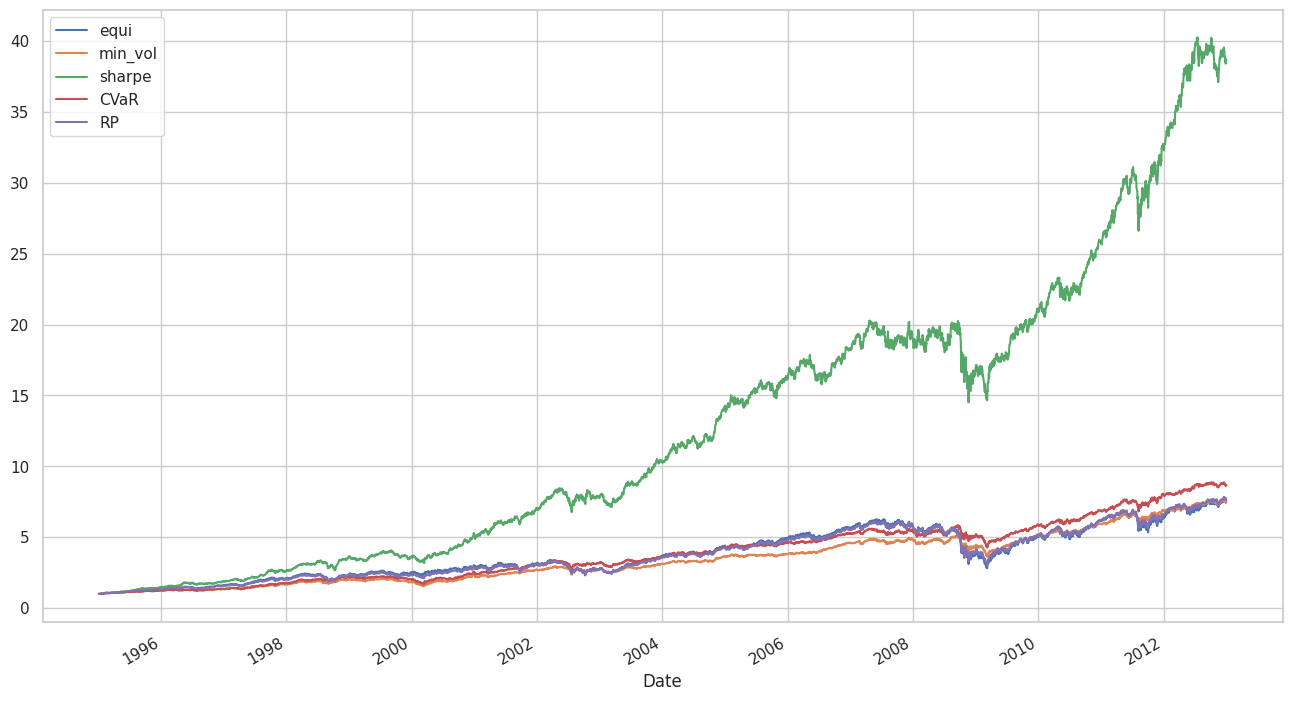

In [14]:
precios_carteras.plot()

In [15]:
retornos_carteras.std()

equi       0.012318
min_vol    0.008000
sharpe     0.010586
CVaR       0.008132
RP         0.011369
dtype: float64

In [16]:
(retornos_carteras.mean() - ret_rf)/retornos_carteras.std()

equi       0.033086
min_vol    0.050626
sharpe     0.072467
CVaR       0.053799
RP         0.036238
dtype: float64

In [17]:
retornos_carteras_test = ret_activos_sp500_test@pesos_carteras.to_numpy()

retornos_carteras_test.columns = pesos_carteras.columns

precios_carteras_test = np.exp(retornos_carteras_test.cumsum())

<Axes: xlabel='Date'>

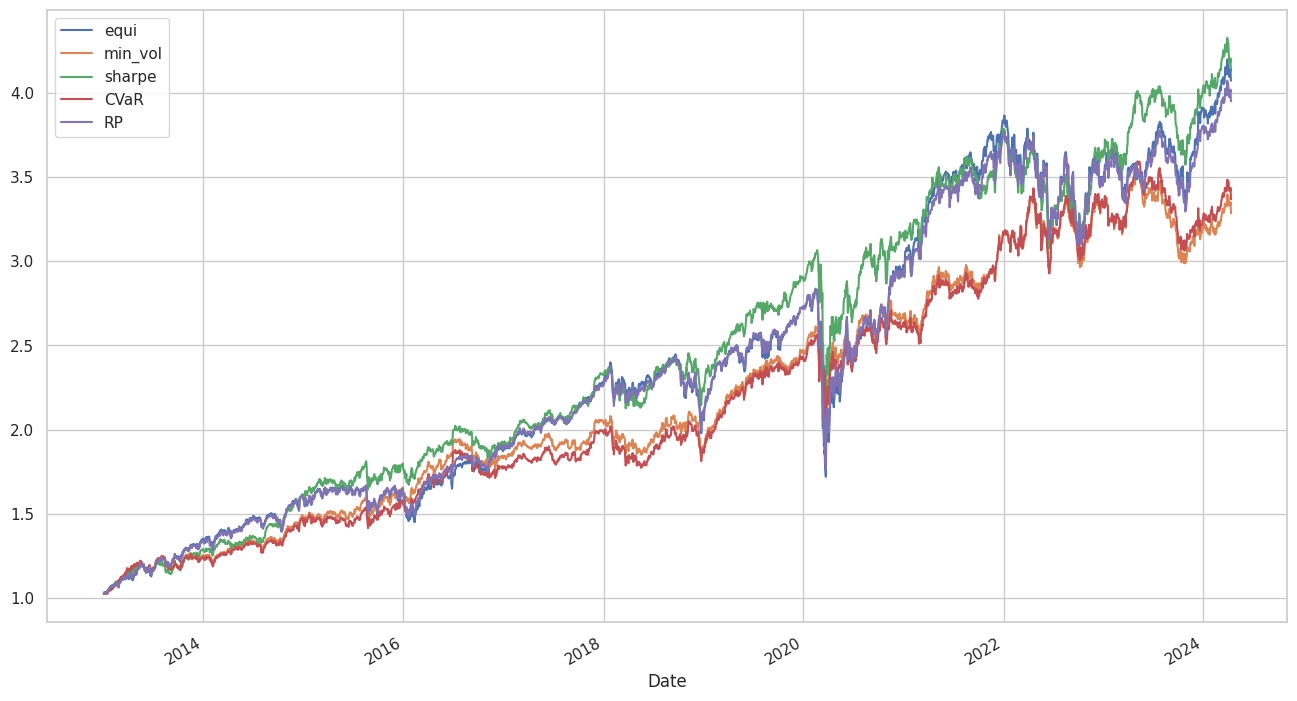

In [18]:
precios_carteras_test.plot()

In [19]:
retornos_carteras_test.std()

equi       0.010924
min_vol    0.008899
sharpe     0.009705
CVaR       0.008875
RP         0.010399
dtype: float64

In [20]:
retornos_carteras_test.quantile(0.05)

equi      -0.016015
min_vol   -0.012544
sharpe    -0.013443
CVaR      -0.012377
RP        -0.015142
Name: 0.05, dtype: float64